In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import matplotlib.pyplot as plt

import pickle
import yaml
import numpy as np
from RetaredHarmonicDynamics import animate_particle
from matplotlib import animation
from scipy.stats import moment
from scipy.special import factorial, lambertw, erf
from pathlib import Path

tensor = torch.tensor

from my_functions import get_pos, get_mean_std, FokkerPlankCalculator, time_delayed_harmonic, damped_harmonic_oszillator
from my_functions import get_approx_freq,get_zero, get_pos_with_border, get_pos_mirror, plot_bullerjahn_analysis

pic_path = Path('Graphic_Results/')

save_run = False

# num_particle = 20000
# border = 0.7e-3
# max_t = 8
# tau = 0
# k = 15
# dt = 4e-3

with open('std_parameter_setting.yaml') as f:
    std_parameter_setting = yaml.load(f , Loader=yaml.SafeLoader)
    
num_res_folder = Path('nummeric_results')/std_parameter_setting['name']
num_res_folder.mkdir(exist_ok=True)
    


num_particle = std_parameter_setting['num_particle']
max_t = std_parameter_setting['max_t']
dt = std_parameter_setting['dt']

tau = std_parameter_setting['tau']
k = std_parameter_setting['k']
border = std_parameter_setting['border']

D = float(std_parameter_setting['D'])

forces = {
    "no": lambda i: 0,
    "const": lambda i:2e-3,
    "ramp": lambda i: 0.005*i/(max_t),
    "oszi": lambda i: 0.005*np.cos(i * 10)
}

# General properties

In [3]:
pos = get_pos_mirror(x_m = border, tau=tau, k=k,D = D, dt=dt, num_particle = 10_000, max_t = 5)

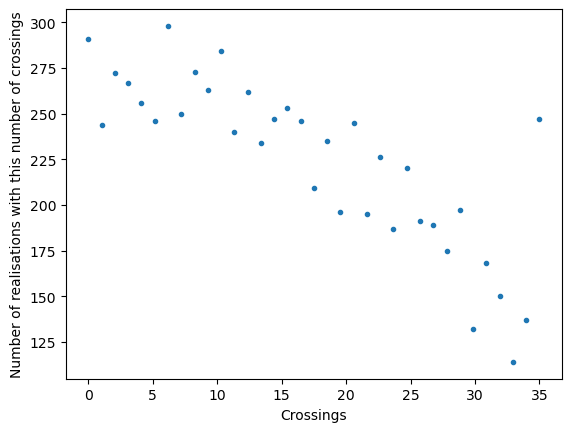

In [4]:
xlim = (0,35)
crossings = ((pos[1:]*1e3)*(pos[:-1]*1e3) < 0).sum(axis=0).float()
hist = crossings.histc(bins=xlim[1], min=xlim[0], max=xlim[1], )
plt.plot(np.linspace(*xlim,xlim[1]),hist,'.')
plt.xlabel('Crossings')
plt.ylabel('Number of realisations with this number of crossings')
crossings_zero_bound = {tau:hist}
# %store crossings_zero_bound
with open(num_res_folder/'crossings_zero_bound.pkl','wb') as f:
    pickle.dump(crossings_zero_bound, f)

Can see that the number is most often even, so maybe the particle is always comming pack

In [5]:
# Same as above for different taus
if False:
    for tau in torch.linspace(0,0.2,5):
        pos = get_pos_mirror(x_m = border, tau=tau.item(), k = k, dt=dt)
        xlim = (0,35)
        crossings = (((pos[1:]*1e3)*(pos[:-1]*1e3)) < 0).sum(axis=0).float()
        hist = crossings.histc(bins=xlim[1], min=xlim[0], max=xlim[1], )
        plt.plot(np.linspace(*xlim,xlim[1]),hist,'.',label=tau.item())
    plt.ylim(-10,1000)
    plt.legend()

In [6]:
# Number of particles moving from left to right
#plt.plot((((pos[1:]*1e3)*(pos[:-1]*1e3)).sign() + pos[:-1].sign() == -2).sum(axis=1))

In [7]:
# Get all crossing events

# *1e3 terms to avoid getting zero because of short float16 length
crossings_events = ((pos[1:]*1e3)*(pos[:-1]*1e3)) < 0
print(crossings_events.shape)
# Gives idxs of crossing events
crossing_times = crossings_events.nonzero()
print(crossing_times.shape)

torch.Size([4999, 10000, 1])
torch.Size([232470, 3])


In [8]:
# Crossing times
res = []
no_crossing = 0
one_crossing = 0
for i in range(5000):
    crossing_time_one_particle = crossing_times[crossing_times[:,0] == i]
    if len(crossing_time_one_particle) == 0:
        no_crossing += 1
    elif len(crossing_time_one_particle) == 1:
        one_crossing += 1
    else:
        res.append(crossing_time_one_particle[1:,1] - crossing_time_one_particle[:-1,1])
print(no_crossing, one_crossing)
if len(res) > 0:
    flat_res = torch.concat(res)
    crossing_time_num = []
    for i in range(15):
        cross_time_i = [o[i] for o in res if len(o) > i]
        if len(cross_time_i) > 0:
            crossing_time_num.append(torch.stack([o[i] for o in res if len(o) > i]))

302 0


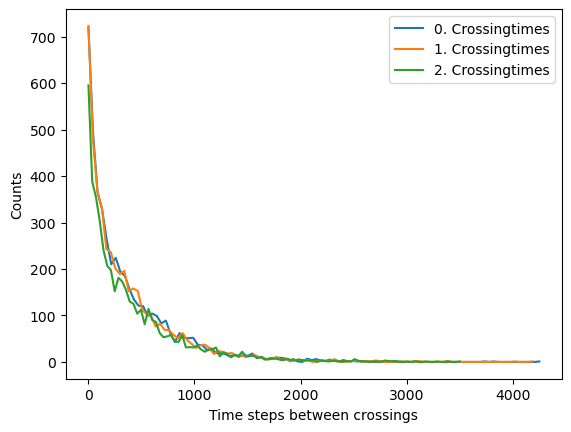

In [9]:
# show different hist of the time between to crossings 

if len(res):
    #plt.hist(flat_res, bins=100)
    for i in range(3):
        #plt.hist(crossing_time_num[i], bins=100,alpha=0.5, label=f'{i}. Crossingtimes')
        if len(crossing_time_num)-1 < i:
            break
        hist, bins = np.histogram(crossing_time_num[i], bins=100)
        plt.plot(bins[:-1], hist, label=f'{i}. Crossingtimes')

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel('Time steps between crossings')
    plt.ylabel('Counts')
    plt.legend()
    plt.show()

In [10]:
# Crossing times for differnet taus
if True:
    taus = torch.linspace(0,0.2,5)
    total_res = []
    for loop_tau in taus:
        pos = get_pos_mirror(x_m = border,
                             tau=loop_tau.item(),
                             k = k,
                             dt = dt,
                             D = D,
                             num_particle = 10_000,
                             max_t = 5)
        crossings_events = ((pos[1:]*1e3)*(pos[:-1]*1e3)) < 0
        crossing_times = crossings_events.nonzero()
        no_crossing = 0
        one_crossing = 0
        for i in range(5000):
            crossing_time_one_particle = crossing_times[crossing_times[:,0] == i]
            if len(crossing_time_one_particle) == 0:
                no_crossing += 1
            elif len(crossing_time_one_particle) == 1:
                one_crossing += 1
            else:
                res.append(crossing_time_one_particle[1:,1] - crossing_time_one_particle[:-1,1])
        print(no_crossing, one_crossing)
        if len(res):
            total_res.append(torch.concat(res))

2969 1251
1031 1371
296 646
167 74
203 4


Text(0, 0.5, 'Counts')

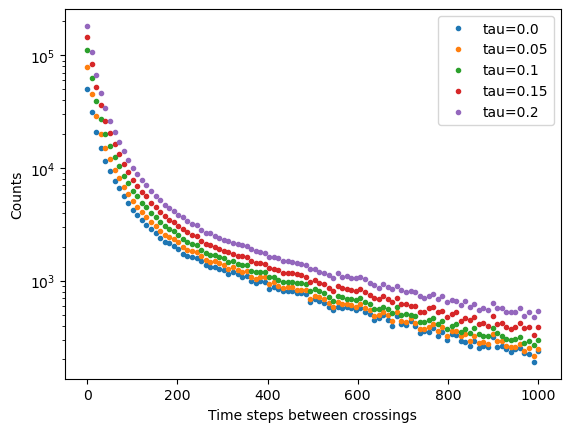

In [11]:
xlim=(0,1000)
for loop_tau,res in zip(taus,total_res):
    hist = res.float().histc(bins=100, min=xlim[0], max=xlim[1], )
    plt.plot(np.linspace(*xlim,100),hist,'.',label=f'tau={round(loop_tau.item(),2)}')
    
plt.yscale('log')
plt.legend()
plt.xlabel('Time steps between crossings')
plt.ylabel('Counts')

# No Froce

In [12]:
def plot_simulated_rate(
    k,
    tau,
    D,
    border,
    dt,
    num_particle,
    max_t,
    F=lambda i:0,
    safe_name=None):
    
    pos = get_pos_mirror(x_m = border,
                         num_particle=num_particle,
                         max_t = max_t,
                         dt = dt,
                         tau=tau,
                         k=k,
                         D=D,
                         F=F)
    print('got', len(pos))
    time = np.linspace(0,max_t,len(pos))
    particles = (pos < 0).sum(1)

    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].plot(time,particles)
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Number of particles')

    p_diff_raw = particles.diff(dim=0)*1.
    crossings_raw = (((pos[1:]*1e3)*(pos[:-1]*1e3)).sign() + pos[:-1].sign() == -2).sum(axis=1)+0.
    p_diff = p_diff_raw.clone()
    crossings = crossings_raw.clone()
    
    mean_bin = 50
    p_diff = p_diff.squeeze()
    p_diff = torch.stack([p_diff.repeat(mean_bin,1).diag(i).mean() for i in range(len(p_diff)-mean_bin)])
    p_diff = p_diff.unsqueeze(1)
    time_s = time[mean_bin//2:-mean_bin//2-1]
    
    crossings = crossings.squeeze()
    crossings = torch.stack([crossings.repeat(mean_bin,1).diag(i).mean() for i in range(len(crossings)-mean_bin)])
    crossings = crossings.unsqueeze(1)
    
    # for i in range(500):
    #     p_diff[1:-1] = (p_diff[2:]+p_diff[1:-1]+p_diff[:-2])/3
    #     p_diff[0] = (p_diff[0]+p_diff[1])/2
    #     p_diff[-1] = (p_diff[-1]+p_diff[-2])/2
    #     crossings[1:-1] = (crossings[2:]+crossings[1:-1]+crossings[:-2])/3
    #     crossings[0] = (crossings[0]+crossings[1])/2
    #     crossings[-1] = (crossings[-1]+crossings[-2])/2
    axs[1].plot(time[:-1],p_diff_raw, alpha=0.2, label='raw')
    axs[1].plot(time_s,p_diff, label='smoothed')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Change of number of particles')
    axs[1].legend()
    axs[2].plot(time[:-1],crossings_raw, alpha=0.2, label='raw')
    axs[2].plot(time_s,crossings, label='smoothed')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Crossing left to right of particles')
    axs[2].legend()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    if safe_name:
        plt.savefig(pic_path/f'{safe_name}_particles.pdf')
    plt.show()
    
    rate_raw = -p_diff_raw/particles[1:]/dt
    rate = -p_diff/particles[1+mean_bin//2:-mean_bin//2]/dt
    crossing_rate = crossings/particles[1+mean_bin//2:-mean_bin//2]/dt
    crossing_rate_raw = crossings_raw/particles[1:]/dt
    
    # plt.plot(time[:-1],rate_raw, alpha=0.2)
    # plt.plot(time[:-1],rate)
    
    plt.plot(time[:-1],crossing_rate_raw, alpha=0.2)
    plt.plot(time_s,crossing_rate)
    
    average = 500
    print(rate_raw[-average:].mean(), 1/np.sqrt(average)*rate_raw[-average:].std())
    plt.xlabel("Time")
    plt.ylabel(r"Rate $\kappa$")
    if safe_name:
        plt.savefig(pic_path/f'{safe_name}_rate.pdf')
    plt.show()
    return pos, particles,rate,crossing_rate, time, time_s

got 2000


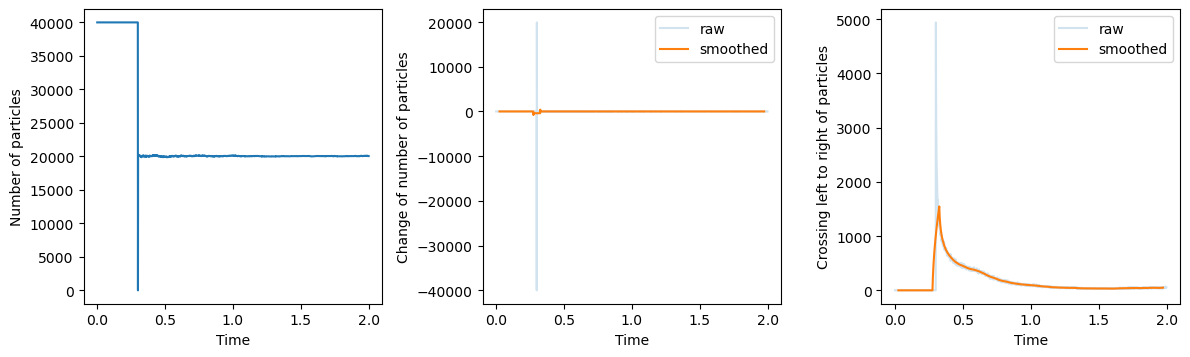

tensor(-0.0005) tensor(0.0202)


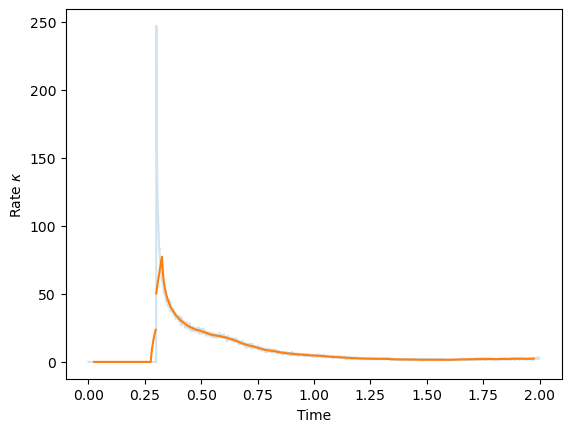

In [13]:
pos, particles_no_force,rate_no_force,crossing_rate_no_force, time_no_force, time_no_force_s = plot_simulated_rate(
    k=k,
    tau=tau,
    D=D,
    border=border,
    num_particle=num_particle,
    max_t=max_t,
    dt=dt,
    F = forces['no'],
    safe_name='no_force')

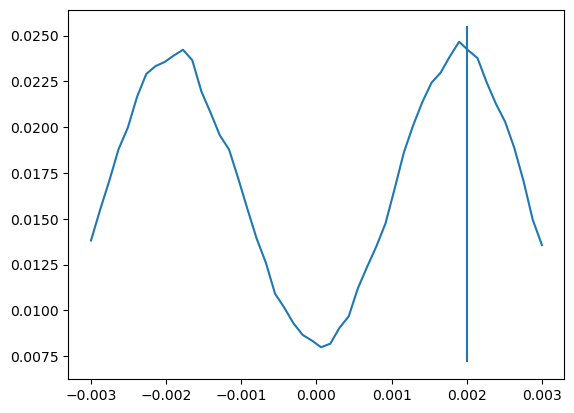

In [14]:
average = 50
xlim = (-3e-3,3e-3)
values = pos[-average:,:,0].flatten()
hist = values[~values.isnan()].float().histc(bins=50, min=xlim[0], max=xlim[1], )/num_particle/average

plt.plot(np.linspace(*xlim,50),hist)
plt.vlines([border],*plt.ylim())

# Constant Force

got 2000


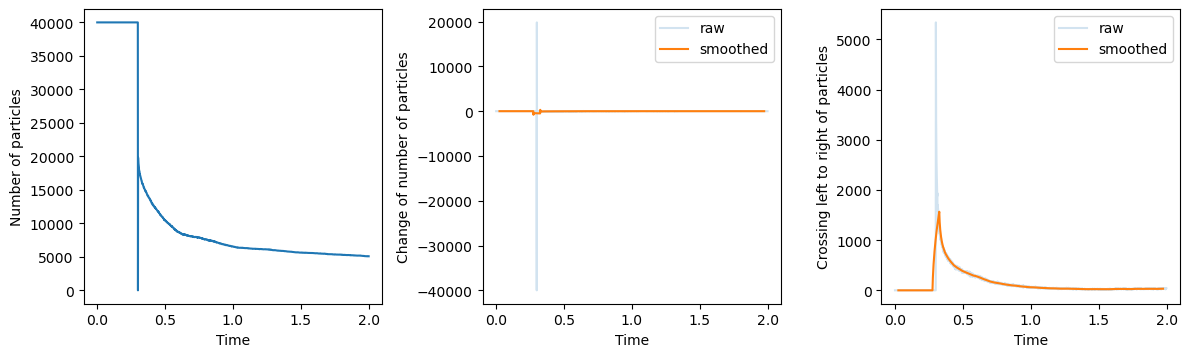

tensor(0.2045) tensor(0.0608)


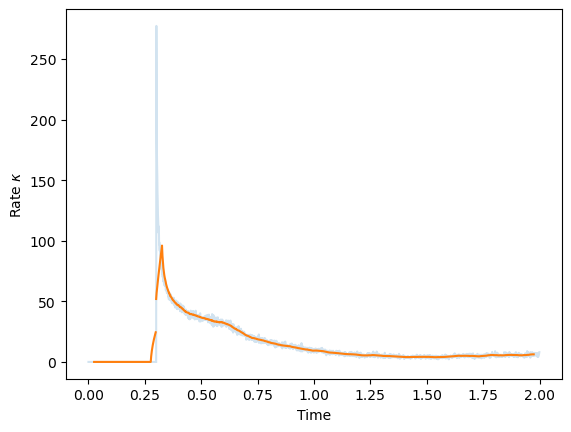

In [15]:
pos, particles_const, rate_const, crossing_rate_const ,time_const, time_const_s = plot_simulated_rate(
    tau=tau,
    k=k,
    D=D,
    num_particle=num_particle,
    border=border,
    F= forces['const'],
    max_t=max_t,
    dt=dt,
    safe_name='const_force')
    
#if torch.__version__ != '1.9.1':
#    plt.plot(pos.nanmean(dim=1))

# Force Ramp

got 2000


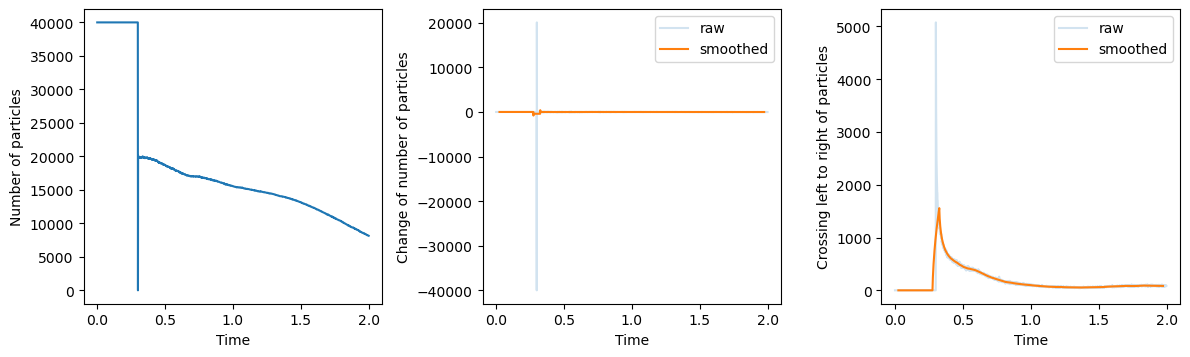

tensor(0.9588) tensor(0.0532)


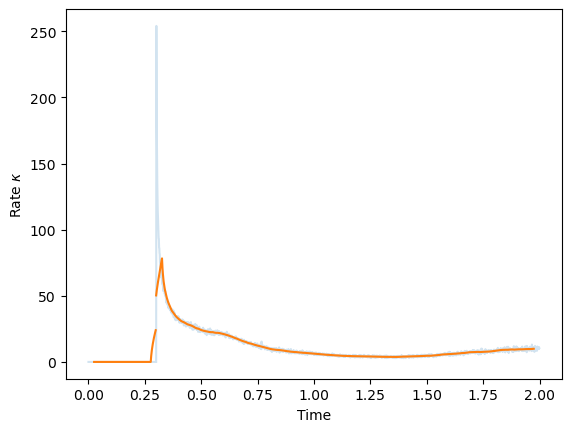

In [16]:
pos,particles_ramp, rate_ramp,crossing_rate_ramp, time_ramp, time_ramp_s = plot_simulated_rate(
    tau=tau,
    k=k,
    D=D,
    num_particle=num_particle,
    border=border,
    F= forces['ramp'],
    max_t = max_t,
    dt=dt,
    safe_name='force_ramp')

#if torch.__version__ != '1.9.1':
#    plt.plot(pos.nanmean(dim=1))

# Oszillatory Force

got 2000


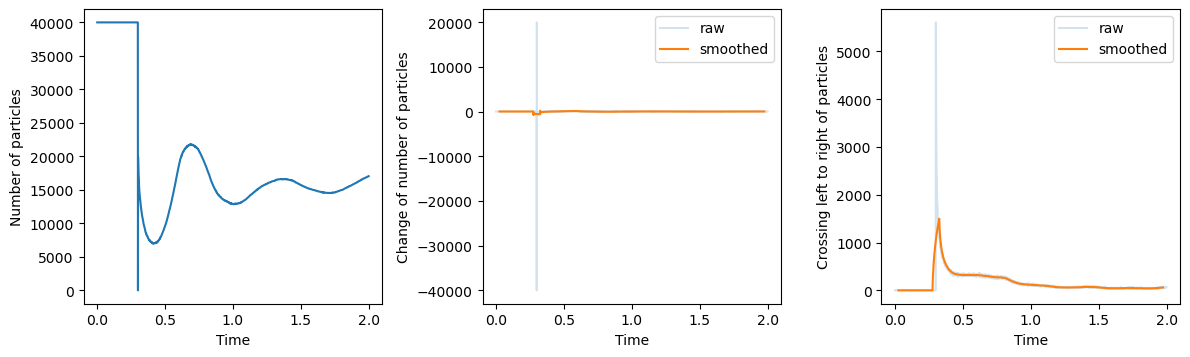

tensor(-0.1613) tensor(0.0348)


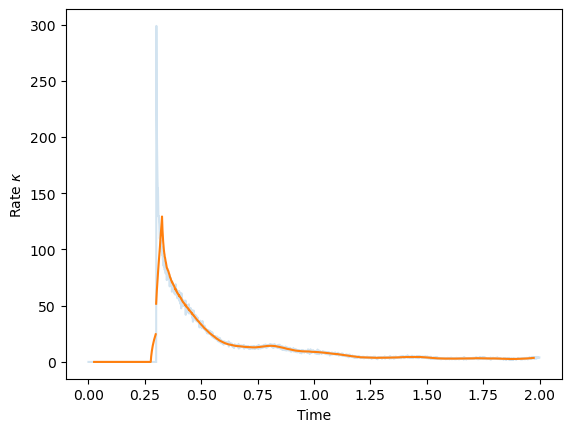

In [17]:
pos, particles_oszi, rate_oszi,crossing_rate_oszi, time_oszi, time_oszi_s = plot_simulated_rate(
    tau = tau,
    k=k,
    D=D,
    num_particle=num_particle,
    border=border,
    F= forces['oszi'],
    max_t = max_t,
    dt=dt,
    safe_name='oszi_force')

#if torch.__version__ != '1.9.1':
#    plt.plot(pos.nanmean(dim=1))

# Bullerjahn

In [18]:
# sim_res = {
#     "no": rate_no_force,
#     "const": rate_const,
#     "ramp": rate_ramp,
#     "oszi": rate_oszi
# }

sim_res = {
    "no": crossing_rate_no_force,
    "const": crossing_rate_const,
    "ramp": crossing_rate_ramp,
    "oszi": crossing_rate_oszi
}

sim_res_num = {
    "no": particles_no_force/num_particle,
    "const": particles_const/num_particle,
    "ramp": particles_ramp/num_particle,
    "oszi": particles_oszi/num_particle
}

forces_bound_zero = forces
sime_res_bound_zero = sim_res
# %store sime_res_bound_zero
with open(num_res_folder/'sime_res_bound_zero.pkl','wb') as f:
    pickle.dump(sime_res_bound_zero, f)

7
1000


/home/nils/Programmieren/overdampedDelayHarmonicOscillator/my_functions.py:403: RuntimeWarning: divide by zero encountered in divide
  j = -(w*b-G-d_prefactor*D_t*(b-mu)/var) * 1 / np.sqrt(2*np.pi*var) * np.exp(-(b-mu)**2/(2*var))
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/my_functions.py:403: RuntimeWarning: invalid value encountered in multiply
  j = -(w*b-G-d_prefactor*D_t*(b-mu)/var) * 1 / np.sqrt(2*np.pi*var) * np.exp(-(b-mu)**2/(2*var))
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/my_functions.py:405: RuntimeWarning: divide by zero encountered in divide
  S = 1/2*(1+erf( (b-mu)/np.sqrt(2*var)))
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/my_functions.py:415: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axs[0,0].set_ylim(0.9*np.sort(G)[11], 1.1*np.sort(G)[-11])


1000
1000
1000


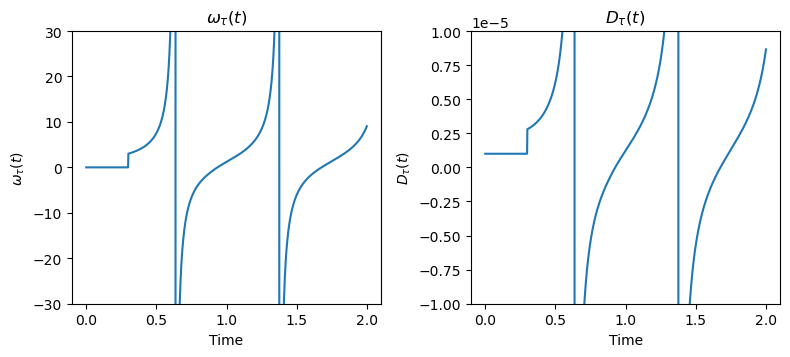

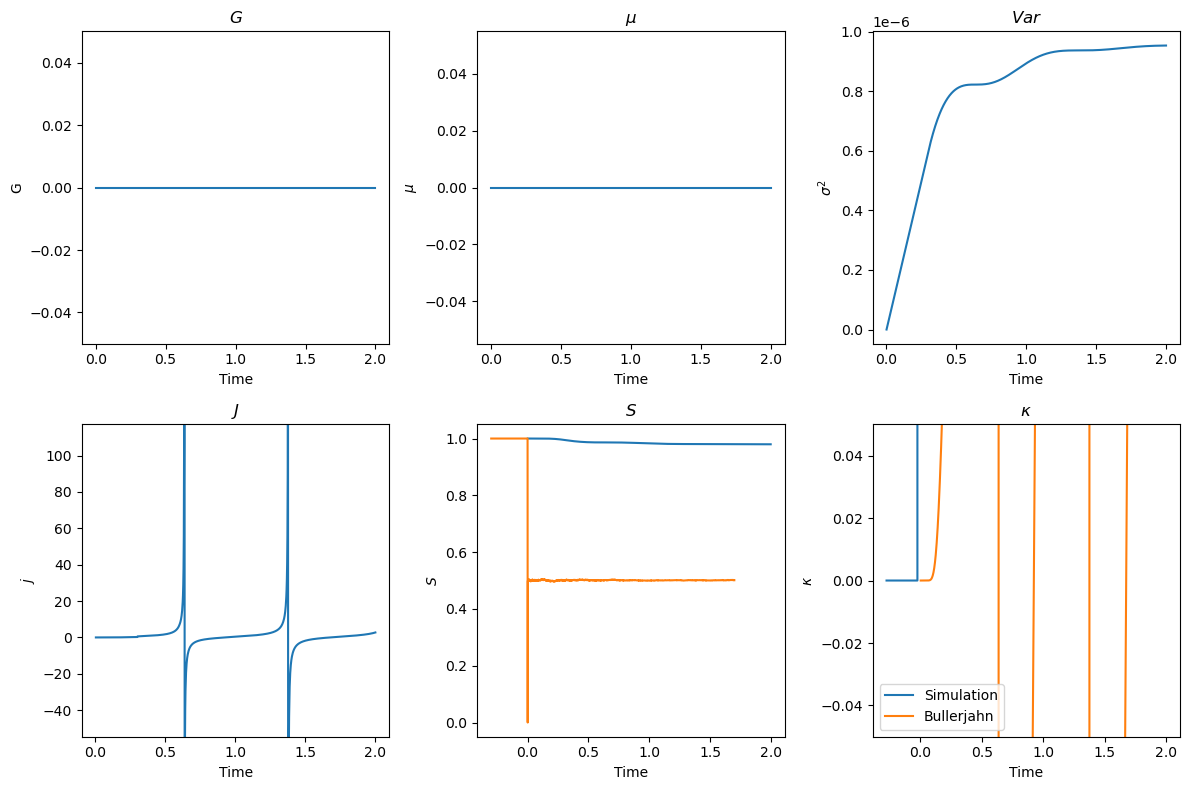

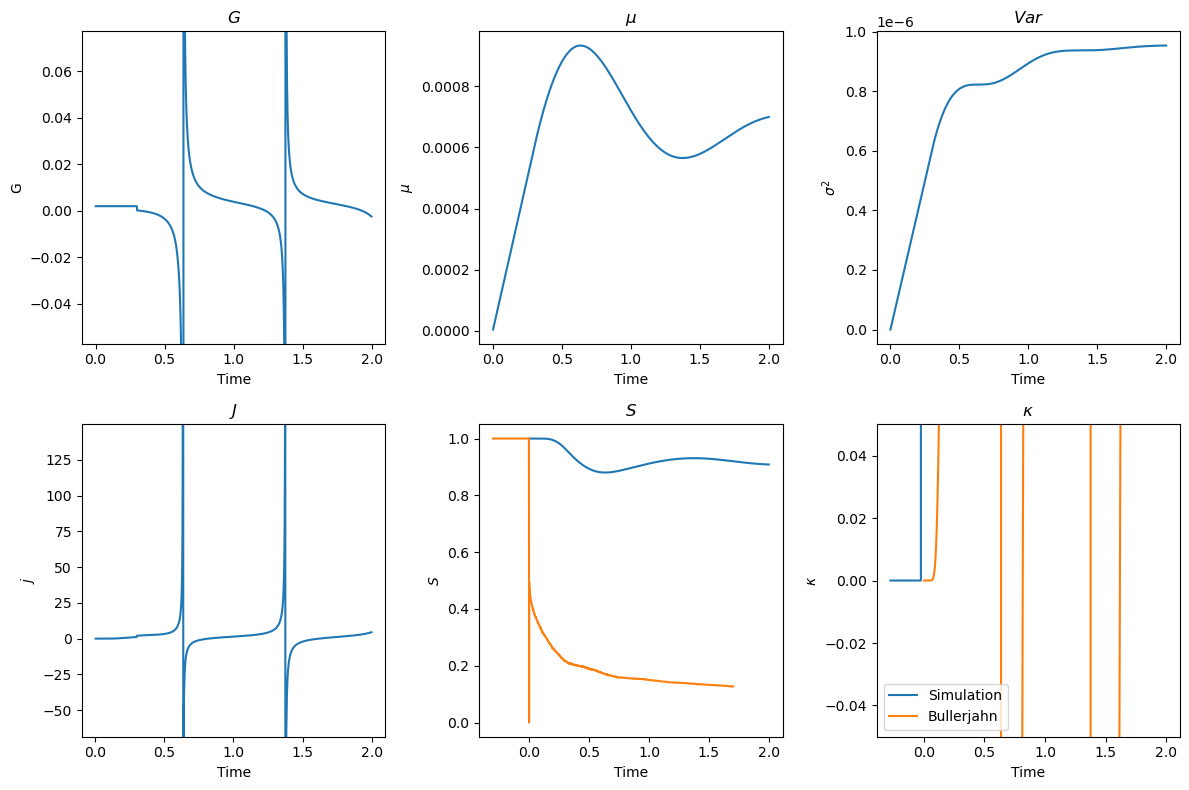

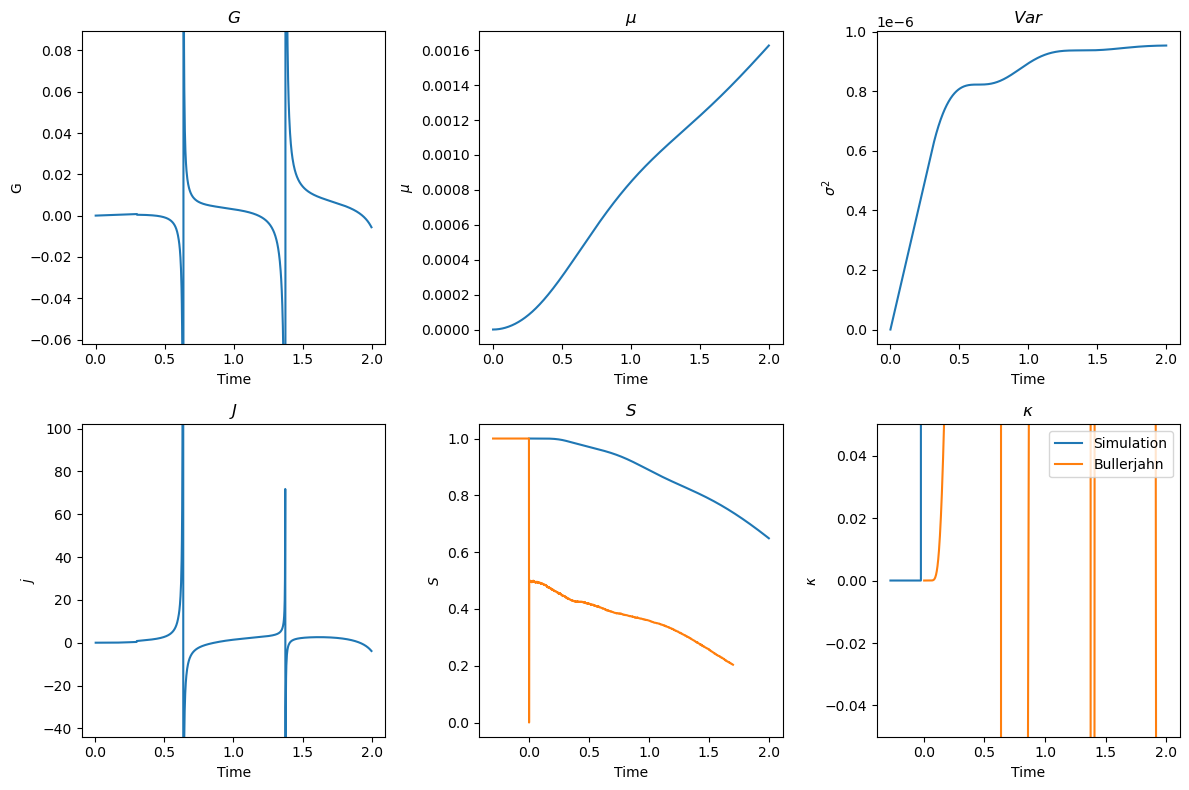

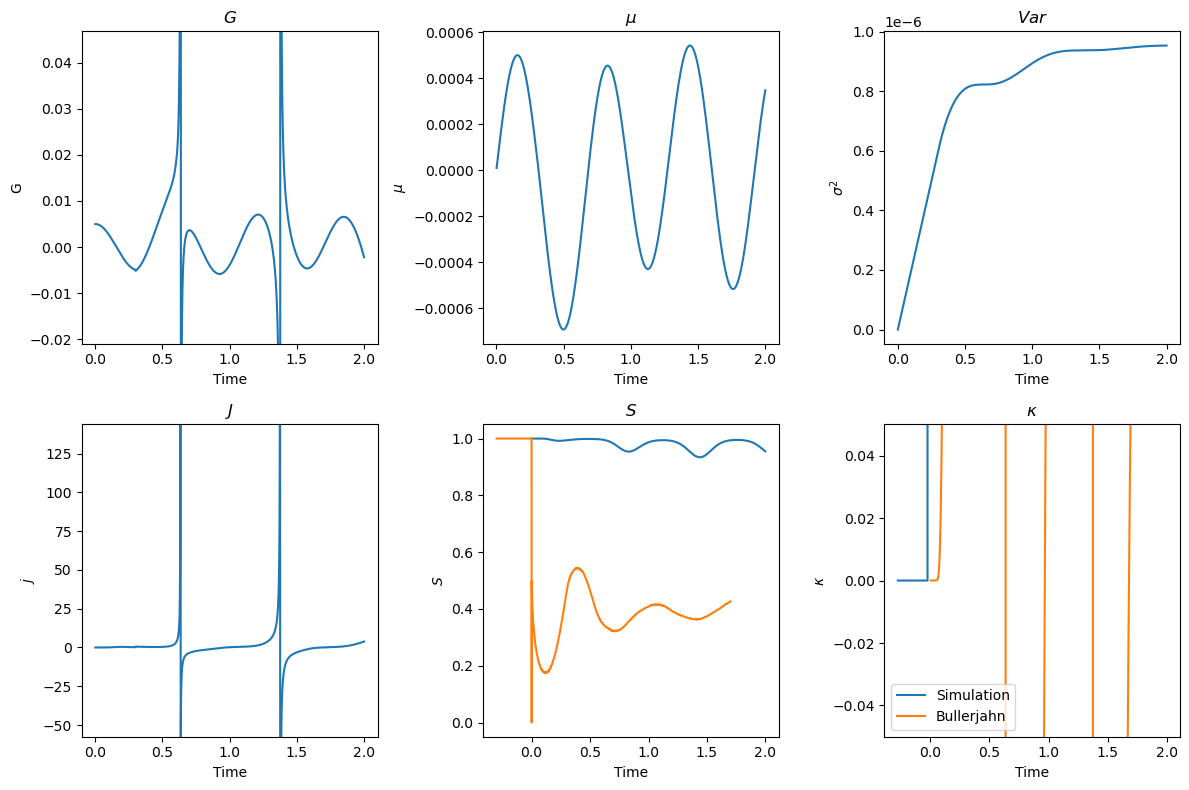

In [19]:
plot_bullerjahn_analysis(max_t, dt, tau, k, D,border, time_ramp_s, sim_res,time_ramp, sim_res_num, forces, save_run)
plt.show()